# Demo: MNIST Classification via a Neural Network

In the the [MNIST SVM example](./demo_mnist_svm.ipynb), we introduced the classic MNIST digit classification problem and trained a simple SVM classifier for the model.  In this demo, we will try a simple neural network.  The network we will create will not perform quite as well -- we will obtain an accuracy of only around 97%, while the SVM classifier obtains an accuracy of over 98%.  However, once we understand these simple neural networks, we will be able to build more sophisticated networks that can obtain much better classification rate.  Also, in doing this demo, you will learn several important features of the `pytorch` package in addition to the concepts shown in the [simple neural network example](./demo_simple_neural.ipynb):

* How to construct multi-class classifiers using categorical cross entropy.
* How to optimize using mini-batches.
* How to save and load the model after training.  

## Loading the Pytorch package and the MNIST data

We first load the `torch` package as in the [simple neural network example](../demo_simple_neural.ipynb), as well as other common packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch

np.random.seed(1) # let's reset the random seed for repeatability

Next, we download the MNIST data, as in the [MNIST SVM example](./demo_mnist_svm.ipynb).  As before, we rescale the input `X` to the interval [-1,1], a form of standardization.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.data.shape

X = np.array(2*(mnist.data/255-0.5))   # Scale X to interval [-1,1]
y = np.array(mnist.target.astype(np.int8)) # fetch_openml() returns targets as stringsp

We also split the data into training and test.  The standard split uses 50,000 examples for training and 10,000 for test.

In [3]:
from sklearn.model_selection import train_test_split
ntr = 50000
nts = 10000

Xtr, Xts, ytr, yts = train_test_split(X,y,train_size=ntr, test_size=nts,shuffle=True)

We will also use the `plt_digit` function from the [MNIST SVM example](./demo_mnist_svm.ipynb) to display digits.

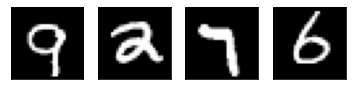

In [4]:
def plt_digit(x):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq,  cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    
# Select random digits
nplt = 4
nsamp = X.shape[0]
Iperm = np.random.permutation(nsamp)

# Plot the images using the subplot command
for i in range(nplt):
    ind = Iperm[i]
    plt.subplot(1,nplt,i+1)
    plt_digit(X[ind,:])

# Create Data Loaders
Create data loaders for both the training and testing sets

In [5]:
import torch.utils.data

batch_size = 100

# Convert the numpy arrays to PyTorch tensors
Xtr_torch = torch.Tensor(Xtr)
ytr_torch = torch.Tensor(ytr)
Xts_torch = torch.Tensor(Xts)
yts_torch = torch.Tensor(yts)

# Create a training Dataset
train_ds = torch.utils.data.TensorDataset(Xtr_torch, ytr_torch)
# Creates a training DataLoader from this Dataset
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True) 

# Create a testing Dataset
test_ds = torch.utils.data.TensorDataset(Xts_torch, yts_torch)
# Creates a testing DataLoader from this Dataset
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size) 


## Creating a Simple Neural Network.

To create the neural network, we first import the appropriate sub-package.

In [6]:
import torch.nn as nn

Now we create a very simple network.  The features are:
*  We have one hidden layer with `nh=100` units and sigmoid activation functions  
*  One output layer with `nout=10` units, one for each of the 10 possible classes
*  We will define the network output as the 2nd stage linear scores, so we don't explicitly implement a softmax
*  Later, we will incorporate the softmax model through the choice of cross-entropy loss

In [7]:
nin = X.shape[1] # dimension of input data
nh = 100 # number of hidden units
nout = int(np.max(y)+1) # number of outputs = 10 since there are 10 classes

class Net(nn.Module):
    def __init__(self,nin,nh,nout):
        super(Net,self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.Dense1 = nn.Linear(nin,nh)
        self.Dense2 = nn.Linear(nh,nout)
        
    def forward(self,x):
        x = self.sigmoid(self.Dense1(x))
        out = self.Dense2(x)
        return out

model = Net(nin=nin, nh=nh, nout=nout)

## Training the Network

As before, to train the network, we first select an optimizer and a loss function.  Since this is a multi-class classification problem, we select the cross-entropy loss.  We use the `optim.Adam` optimizer as before.  You may want to play with the learning rate `lr`.

In [8]:
import torch.optim as optim

opt = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

We will train the network in a similar way to the previous demo.
But this time we will measure loss and accuracy on the test dataset.
When doing so, we do not want to back-propagate the gradient onto the test set.
We ensure this using a `with torch.no_grad()` block to turn off gradient computations.


In [9]:
num_epoch = 30

a_tr_loss = np.zeros([num_epoch])
a_tr_accuracy = np.zeros([num_epoch])
a_ts_loss = np.zeros([num_epoch])
a_ts_accuracy = np.zeros([num_epoch])

for epoch in range(num_epoch):

    model.train() # put model in training mode
    correct = 0 # initialize error counter
    total = 0 # initialize total counter
    batch_loss_tr = []
    # iterate over training set
    for train_iter, data in enumerate(train_loader):
        x_batch,y_batch = data
        y_batch = y_batch.type(torch.long)
        out = model(x_batch)
        # Compute Loss
        loss = criterion(out,y_batch)
        batch_loss_tr.append(loss.item())
        # Compute gradients using back propagation
        opt.zero_grad()
        loss.backward()
        # Take an optimization 'step'
        opt.step()
        # Do hard classification: index of largest score
        _, predicted = torch.max(out.data, 1)
        # Compute number of decision errors
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        
    a_tr_loss[epoch] = np.mean(batch_loss_tr) # Compute average loss over epoch
    a_tr_accuracy[epoch] = 100*correct/total

    model.eval() # put model in evaluation mode
    correct = 0 # initialize error counter
    total = 0 # initialize total counter
    batch_loss_ts = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            labels = labels.type(torch.long)
            outputs = model(images)
            batch_loss_ts.append(criterion(outputs,labels).item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    a_ts_loss[epoch] = np.mean(batch_loss_ts)
    a_ts_accuracy[epoch] = 100*correct/total
    # Print details every print_mod epoch
    print('Epoch: {0:2d}   Train Loss: {1:.3f}   '.format(epoch+1, a_tr_loss[epoch])
          +'Train Acc: {0:.2f}    Test Loss: {1:.3f}   '.format(a_tr_accuracy[epoch], a_ts_loss[epoch])
          +'Test Acc: {0:.2f}'.format(a_ts_accuracy[epoch]))
        

Epoch:  1   Train Loss: 0.627   Train Acc: 85.62    Test Loss: 0.328   Test Acc: 90.81
Epoch:  2   Train Loss: 0.274   Train Acc: 92.19    Test Loss: 0.255   Test Acc: 92.71
Epoch:  3   Train Loss: 0.219   Train Acc: 93.65    Test Loss: 0.220   Test Acc: 93.69
Epoch:  4   Train Loss: 0.182   Train Acc: 94.72    Test Loss: 0.197   Test Acc: 94.20
Epoch:  5   Train Loss: 0.157   Train Acc: 95.49    Test Loss: 0.184   Test Acc: 94.68
Epoch:  6   Train Loss: 0.137   Train Acc: 96.16    Test Loss: 0.160   Test Acc: 95.32
Epoch:  7   Train Loss: 0.121   Train Acc: 96.58    Test Loss: 0.152   Test Acc: 95.59
Epoch:  8   Train Loss: 0.109   Train Acc: 96.86    Test Loss: 0.136   Test Acc: 95.94
Epoch:  9   Train Loss: 0.098   Train Acc: 97.31    Test Loss: 0.136   Test Acc: 95.89
Epoch: 10   Train Loss: 0.089   Train Acc: 97.54    Test Loss: 0.128   Test Acc: 96.23
Epoch: 11   Train Loss: 0.080   Train Acc: 97.77    Test Loss: 0.122   Test Acc: 96.51
Epoch: 12   Train Loss: 0.074   Train Acc: 

We now plot the training accuracy and test accuracy as a function of epoches.
We see that the training accuracy keeps growing to 1, while the test accuracy saturates to a value around 0.97

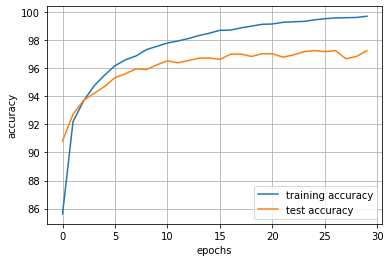

In [10]:
plt.plot(a_tr_accuracy)
plt.plot(a_ts_accuracy)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'test accuracy'])

## Saving and Loading the model

Since the training can take a while, we demonstrate how the trained network can be saved. For a more complete tutorial on saving and loading pytorch models, see https://pytorch.org/tutorials/beginner/saving_loading_models.html.

Here we will save the state dictionary, which contains the network parameters learned during training.

In [11]:
PATH = 'saved_model.pt'
torch.save(model.state_dict(), PATH)

Now we will reinitialize the network model (which clears its data), and then demonstrate that we can reload the state dictionary using the `load_state_dict` command.

In [12]:
model = Net(nin=nin, nh=nh, nout=nout)
model.load_state_dict(torch.load(PATH))
model.eval()

Net(
  (sigmoid): Sigmoid()
  (Dense1): Linear(in_features=784, out_features=100, bias=True)
  (Dense2): Linear(in_features=100, out_features=10, bias=True)
)

Now we demonstrate that we can apply the network to the test data, yielding the same performance as before.

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        labels = labels.type(torch.long)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    acc = 100*correct/total
print("accuracy = %f" % acc)

accuracy = 97.230000
